In [11]:
import gc
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix, hstack

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

In [51]:
train_path = '../data/train.tsv'
test_path = '../data/test.tsv'

- Feature explanation

train_id — the id of the listing

name — the title of the listing

item_condition_id — the condition of the items provided by the sellers

category_name — category of the listing

brand_name — the name of the brand

price — the price that the item was sold for. This is target variable that we will predict

shipping — 1 shipping fee is paid by seller; 0 by buyer
       
item_description — the full description of the item

In [21]:
df = pd.read_csv('../data/train.tsv', sep = '\t')
display(df.head(5))
print(df.shape)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


(1482535, 8)

In [10]:
#generate array of random numbers between [0,1) of df's length then return a array of boolean about whether value in array smaller than 0.8
#random.rand generate an uniform distribution
#numbers smaller 0.8 sets be True and others sets to be False which gives about 80% True values 
msk = np.random.rand(len(df)) < 0.8
#use array of boolean as slice to return only True value rows 
train = df[msk]
#tilde symbol invert the values in the array and it is bitwise element invert
#~msk means invert True or False in array to the opposite
test = df[~msk]
train.shape, test.shape

((1186218, 8), (296317, 8))

In [34]:
display(train.head(5))
print(train.info())

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1186218 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1186218 non-null int64
name                 1186218 non-null object
item_condition_id    1186218 non-null int64
category_name        1181190 non-null object
brand_name           679488 non-null object
price                1186218 non-null float64
shipping             1186218 non-null int64
item_description     1186216 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 81.5+ MB
None


In [35]:
train.price.describe()

count    1.186218e+06
mean     2.674884e+01
std      3.865964e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.006000e+03
Name: price, dtype: float64

Text(0.5, 1.0, 'Price Distribution')

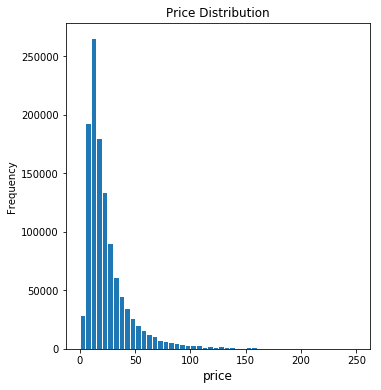

In [36]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)
# looks like a skewd long tail distribution, need to be transfer to a normal distribution to use other prediction tools

Text(0.5, 1.0, 'Price Distribution')

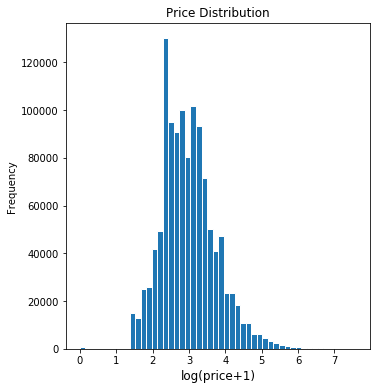

In [37]:
plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)

In [38]:
train['shipping'].value_counts() / len(train)

0    0.55249
1    0.44751
Name: shipping, dtype: float64

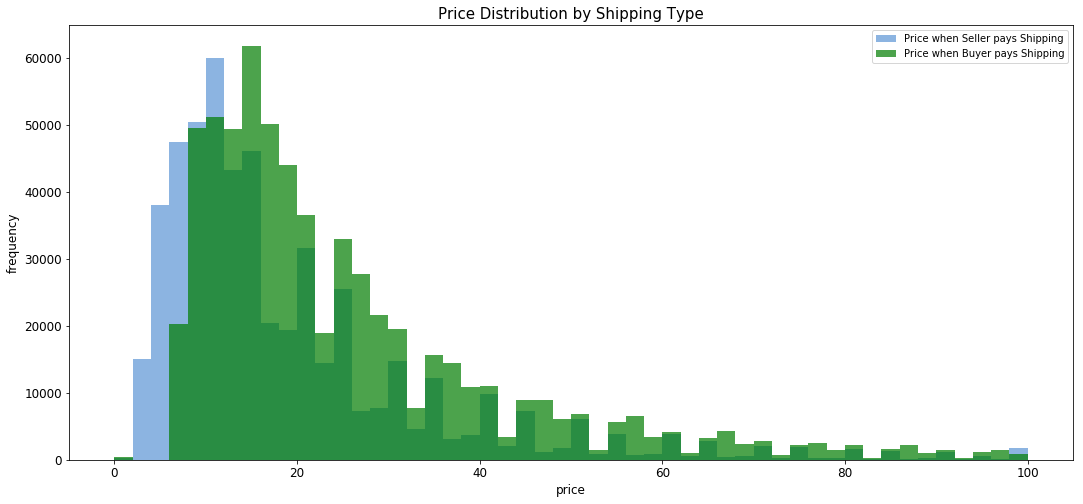

In [39]:
shipping_fee_by_buyer = train.loc[df['shipping'] == 0, 'price']
shipping_fee_by_seller = train.loc[df['shipping'] == 1, 'price']

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(shipping_fee_by_seller, color='#8CB4E1', alpha=1.0, bins=50, range = [0, 100],
       label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color='#007D00', alpha=0.7, bins=50, range = [0, 100],
       label='Price when Buyer pays Shipping')

plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [40]:
print('The average price is {}'.format(round(shipping_fee_by_seller.mean(), 2)), 'if seller pays shipping');
print('The average price is {}'.format(round(shipping_fee_by_buyer.mean(), 2)), 'if buyer pays shipping')

The average price is 22.59 if seller pays shipping
The average price is 30.12 if buyer pays shipping


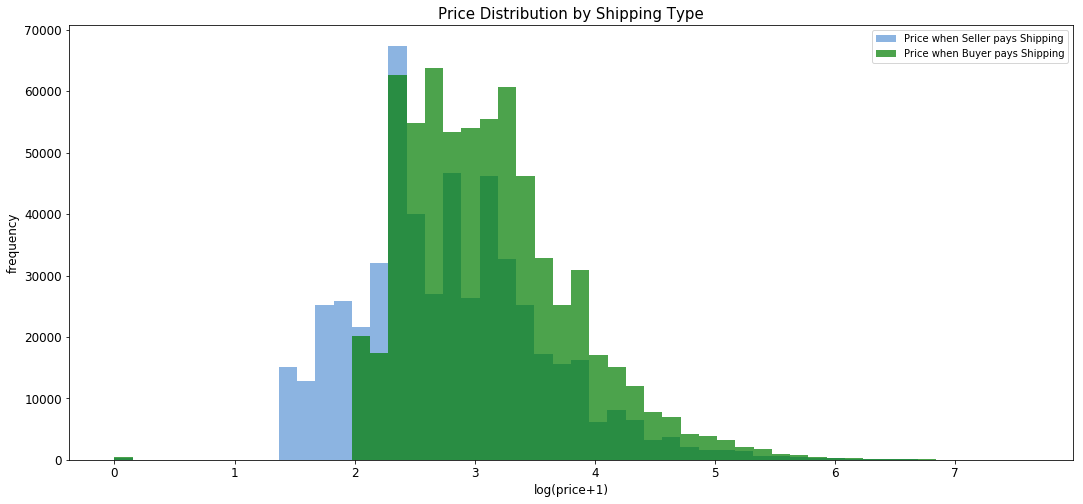

In [41]:
fig, ax = plt.subplots(figsize=(18,8))

ax.hist(np.log(shipping_fee_by_seller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(shipping_fee_by_buyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')

plt.xlabel('log(price+1)', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [42]:
print('There are', train['category_name'].nunique(), 'unique values in category name column')

There are 1265 unique values in category name column


In [43]:
train['category_name'].value_counts()[:10]

Women/Athletic Apparel/Pants, Tights, Leggings                 48111
Women/Tops & Blouses/T-Shirts                                  37071
Beauty/Makeup/Face                                             27556
Beauty/Makeup/Lips                                             23814
Electronics/Video Games & Consoles/Games                       21215
Beauty/Makeup/Eyes                                             20248
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    19713
Women/Underwear/Bras                                           17060
Women/Tops & Blouses/Tank, Cami                                16286
Women/Tops & Blouses/Blouse                                    16236
Name: category_name, dtype: int64

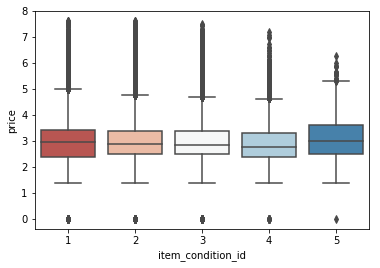

In [44]:
sns.boxplot(x = 'item_condition_id', y = np.log(train['price']+1), data = train, palette = sns.color_palette('RdBu',5))

In [45]:
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

In [46]:
print('There are %d items that do not have a category name.' %train['category_name'].isnull().sum())

There are 5028 items that do not have a category name.


In [47]:
print('There are %d items that do not have a brand name.' %train['brand_name'].isnull().sum())

There are 506730 items that do not have a brand name.


In [48]:
print('There are %d items that do not have a description.' %train['item_description'].isnull().sum())

There are 2 items that do not have a description.


In [49]:
def handle_missing_inplace(dataset): 
    dataset['category_name'].fillna(value='missing', inplace=True) 
    dataset['brand_name'].fillna(value='missing', inplace=True) 
    dataset['item_description'].replace('No description yet,''missing', inplace=True) 
    dataset['item_description'].fillna(value='missing', inplace=True)
    
def cutting(dataset):
    #get first 4000 rows of most famous brands and set others as missing
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    #do the same thing to category_name columns but not actually doing cut?!
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]
    
def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

In [52]:
df = pd.read_csv(train_path, sep = '\t')

msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

test_new = test.drop('price', axis=1)
y_test = np.log1p(test["price"])
train = train[train.price != 0].reset_index(drop=True)

In [53]:
nrow_train = train.shape[0]
y = np.log1p(train["price"])
# just an annotations to tell merge is a pd.DF type variable
merge: pd.DataFrame = pd.concat([train, test_new])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
handle_missing_inplace(merge)
cutting(merge)
to_categorical(merge)

In [68]:
# the minimum apearance of term amont documents to be ignored in convertaion 
#in this case ,if any term in goods name appears less than 10 amount all document, it will be ignored.
cv = CountVectorizer(min_df = NAME_MIN_DF)
X_name = cv.fit_transform(merge['name'])

cv = CountVectorizer()
X_category = cv.fit_transform(merge['category_name'])

In [69]:
tv = TfidfVectorizer(max_features = MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(merge['item_description'])

In [76]:
merge['brand_name'].dtype

CategoricalDtype(categories=['% Pure', '10.Deep', '21men', '24/7 Comfort Apparel', '2XU',
                  '3.1 Phillip Lim', '3M®', '47 Brand', '5.11 Tactical',
                  '525 America',
                  ...
                  'rue', 'sandro', 'seeyou', 'theBalm', 'timi & leslie',
                  'tokidoki', 'totes ISOTONER', 'triangl swimwear',
                  'vineyard vines', 'wallis'],
                 ordered=False)

In [78]:
merge['brand_name'].astype('category', inplace = True)

lb = LabelBinarizer(sparse_output=True)
#it will raise a error if tolist is not added here
X_brand = lb.fit_transform(merge['brand_name'].tolist())

In [79]:
X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse=True).values)

In [80]:
sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()

In [81]:
#np.clip is a function to strict numbers in array to be between minimum and maxium, in this case all number smaller than 0 will set to 0
#getnnz will get the count of explicitly-stored values in sparse matrix
mask = np.array(np.clip(sparse_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool)
sparse_merge = sparse_merge[:, mask]

In [82]:
X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_train:]

In [83]:
train_X = lgb.Dataset(X, label=y)

In [84]:
params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
    }

In [87]:
time_s = time.time()

gbm = lgb.train(params, train_set=train_X, num_boost_round=3200, verbose_eval=100)

time_e = time.time()
print('training complete and it takes {}'.format(time_e - time_s))

training complete and it takes 633.4325230121613


In [88]:
y_pred = gbm.predict(X_test, num_iteration = gbm.best_iteration)

In [91]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#if the predictions are all correct, RMSE is 0. if all predictions are wrong, that value will at least higher than average of dependent variable
# so a close to zero rmse is good and bigger than average of target is very bad.

print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
print('The r2 of prediction is:', r2_score(y_test, y_pred))

The rmse of prediction is: 0.4605908038515705
The r2 of prediction is: 0.6227457858969738


In [93]:
print(y_test.describe())

count    296514.000000
mean          2.978343
std           0.749892
min           0.000000
25%           2.397895
50%           2.890372
75%           3.401197
max           7.604396
Name: price, dtype: float64
